# Classifying Images of Clothing

This guide uses the Fashion MNIST dataset, which contains 70,00 grayscale images in 10 categories.  The images show individual articles of clothing at low resolution (28x28 pixels)

We are going to use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. 

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [ ]:
# %pip install -U tensorflow_datasets

In [ ]:
# %pip install --upgrade pip

In [1]:
#Import tensorflow and datasets

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)



In [2]:
#Split the dataset
    #Train and Test dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

#class names
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))



Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [3]:
#Explore the data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of testing examples: 10000


The value of each pixel in the image data is an integer in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0,1].  So here we create a normalization function, and then appply it to each image in the test and train datsets.

In [4]:
#Preprocess the data
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, lablels

    #The map function applies the normalize function to each element in the train
    #and test datasets    
    train_dataset = train_dataset.map(normalize)
    test_dataset = test_dataset.map(normalize)
    
    #The first time you use the dataset, the image will be loaded from disk
    #Caching will keep them in memory, making training faster
    train_dataset = train_dataset.cache()
    test_dataset = test_dataset.cache()
    


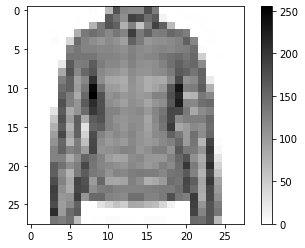

In [5]:
#Explore the processed data

    #We take a single image and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))
    
 #plot the image 
plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


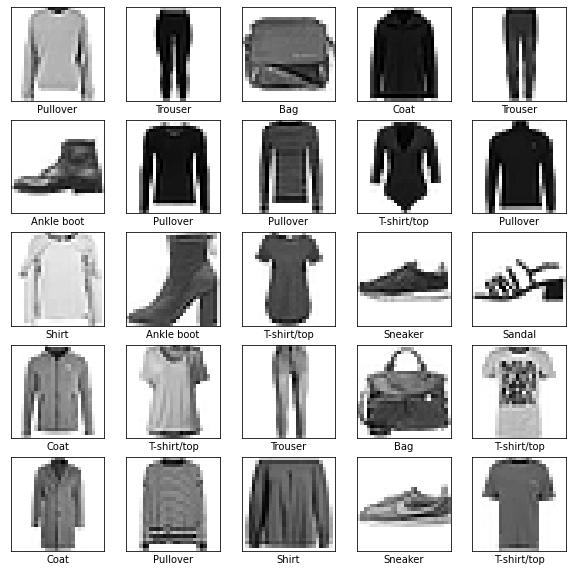

In [6]:
plt.figure(figsize = (10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap = plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Build the model
Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the Layers
The basic building blocks of a neural network is the layer.  A layer extracts a representation from the data fed into it.  Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of the deep learing consists of chaining together simple layers.  Most layers, like tf.keras.layers.Dense, have internal parameters which are adjusted (learned) during training.

In [7]:
# Model
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(128, activation = tf.nn.relu),
        tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

### This network has three layers:

input: tf.keras.layers.Flatten — This layer transforms the images from a 2d-array of 28  ×  28 pixels, to a 1d-array of 784 pixels (28*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

"hidden": tf.keras.layers.Dense— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

output: tf.keras.layers.Dense — A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

In [8]:
#Compile the model

model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

#Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
#Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
#Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.



In [9]:
#Train the model
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)



In [11]:
#Fit the model
model.fit(train_dataset, epochs = 5, steps_per_epoch = math.ceil(num_train_examples/BATCH_SIZE))

#NOTE: train_dataset - used to feed the training data to the model
#      The model learns to associate images and labels
#      epochs=5 - parameter limits training to 5 full iterations of the 60,000 training dataset.
#                 total of 5*60,000 = 300,000 examples 


Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4863 - accuracy: 0.8294
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4836 - accuracy: 0.8305
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4734 - accuracy: 0.8367
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.4673 - accuracy: 0.8389
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4685 - accuracy: 0.8374


## Training results

As the model trains, the loss and accuracy metrics are displayed.  This model reaches an average accuracy of about 0.74816 (75%) on the training data.


In [12]:
#Evaluate the Accuracy
#Compare how the model performs on the test dataset.  Use all examples we have in the test dataset to assess accuracy.
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print('Accuracy on the test dataset:', test_accuracy )



313/313 [==============================] - 2s 6ms/step - loss: 0.5712 - accuracy: 0.8290
Accuracy on the test dataset: 0.8289999961853027


## Testing results ( First Attempt)

The accuracy on the test dataset is greater than the average accuracy on the train dataset. It needs to be noted that the test_accuracy is greater than the average train_dataset used on the model.  

The model's performance improved on it's first test.  Which is opposite to what we should expect the model to do.  Since the model has never seen any of the images in the testing phase and has only seen the images during the training phase.  

In [13]:
# Make Predictions and Explore

for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [14]:
predictions.shape

(32, 10)

In [15]:
predictions[0]

array([6.7886096e-05, 1.5662585e-05, 5.3658377e-02, 2.0789019e-04,
       9.2149252e-01, 1.7171374e-34, 2.4557693e-02, 0.0000000e+00,
       7.9274738e-09, 8.2464258e-36], dtype=float32)

### First Prediction
The predictions above are an arra of 10 numbers.  These describe the 'confidence' of the model that the 10 different articles of clothing.  Recall that the clothing class names are the following:
 
Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot


In [16]:
np.argmax(predictions[0])
#We can see that the model is most confident about image coats, class_name[4]


4

In [17]:
test_labels[0]
#According to our test labels we have the correct highest confidence value:


4

In [18]:
#Graphing the full set of 10 class predictions.
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

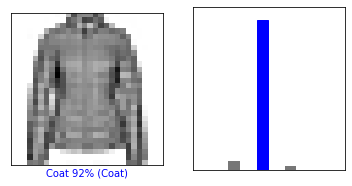

In [19]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

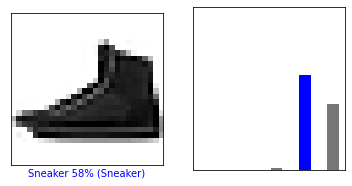

In [20]:
i = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

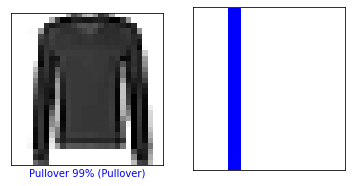

In [21]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

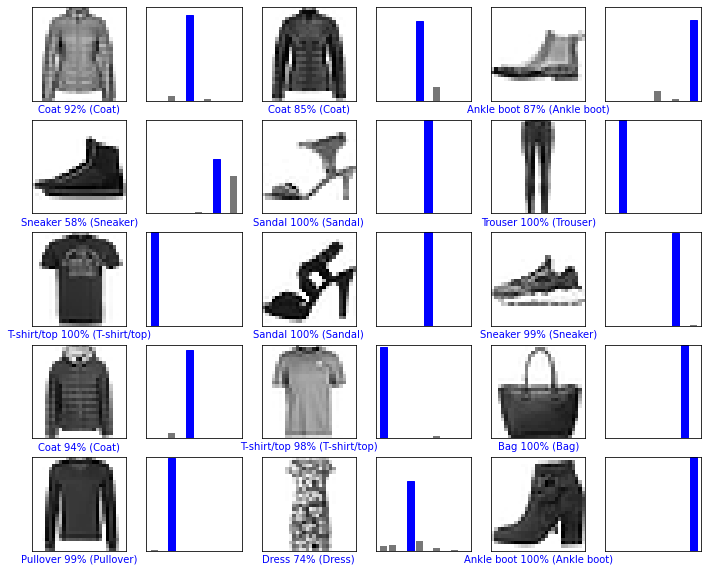

In [22]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


### Final Test
We are going to use the model to make a prediction about an 

In [23]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [24]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [25]:
predictions_single = model.predict(img)

print(predictions_single)

[[6.7885601e-05 1.5662470e-05 5.3658187e-02 2.0788946e-04 9.2149282e-01
  1.7170986e-34 2.4557607e-02 0.0000000e+00 7.9273859e-09 8.2461768e-36]]


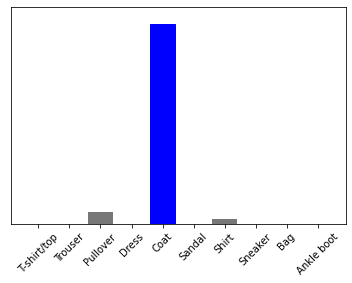

In [26]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [27]:
np.argmax(predictions_single[0])

4

## Result
The model was able to predict a label of 4.  Which is the class name coat.
